**File name**: evaluation_roms.ipynb

**Author**:  Ueslei Adriano Sutil

**Email**: [ueslei@outlook.com](mailto:ueslei@outlook.com)

**Created**: 01 September 2020

**Last modified**: 09 September 2020

**Version**: 2.0

**Python**: 3.7.9
- - -
<br>


** 1. Evaluate ROMS output using:**

- Bias (Contour);
<br>
$
\begin{equation}
BIAS = A_{t}-F_{t}
\end{equation}
$

- Root Mean Square Error (RMSE; Contour);
<br>
$
\begin{equation}
RMSE = \sqrt{\sum_{i=1}^{n}\frac{(A_{t}-F_{t})^2}{n}}
\end{equation}
$
- Mean Absolute Error (MAE; Contour);
<br>
$
\begin{equation}
MAE =  \sum \frac{\left |  F_{t} -  A_{t} \right |}{n}
\end{equation}
$
<br>

- Mean Absolute Percentage Error (MAPE; Contour);
<br>
$
\begin{equation}
MAPE = \frac{\sum \frac{\left | A_{t}- F_{t} \right |}{A_{t}} \times 100}{N}
\end{equation}
$
<br>

Where $A_{t}$ is the actual value, $F_{t}$ is the forecast value and $n$ is the number of observations.
<br>

** 2. Compare ROMS output with:**
- GLORYS12V1 (Fernandez & Lellouch, 2018; [[Access here]](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030)):)
    - Sea Surface Temperature (°C);
    - Current Speed at surface (m.s⁻¹).

- OSCAR (Bonjean & Lagerloef et al., 2002; [[Access here]](https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_third-deg)):
    - Ocean Current Speed at surface (m.s⁻¹);


** 3. Disclaimers: **
- Both Observed and Simulated variables needs to match the same time-step. 
- In my case, ROMS has a better spatial resolution than both database. If your project is the other way around, you need to reverse the order of orig/target.
- What I use to post-process ROMS outputs to match with the databases:<br>
  
    - MUR and GLORYS (Daily data):<br>
            `ncks -v temp,u,v -d s_rho,29,29 roms_his.nc roms_evaluation.nc`<br>
            `cdo daymean roms_evaluation.nc roms_evaluation_mean.nc`<br>
            `cdo splitday roms_evaluation_mean.nc roms_evaluation_mean`<br>
            `cdo cat roms_evaluation_mean01 roms_evaluation_mean02 ... roms_ts_daymean.nc`<br>
   
    - OSCAR (Each 5 days data):<br>
            `ncks -v u,v -d s_rho,49,49 roms_avg.nc roms_evaluation.nc`<br>
            `cdo daymean roms_evaluation.nc roms_evaluation_mean.nc`<br>
            `cdo splitday roms_evaluation_mean.nc roms_evaluation_mean`<br>
            `cdo cat roms_evaluation_mean21 roms_evaluation_mean26 roms_evaluation_final.nc`

- - -

** 1. Import libraries. **

In [1]:
import netCDF4
import pyresample
import cmocean
import os
import numpy                as np
import matplotlib.pyplot    as plt
from   mpl_toolkits.basemap import Basemap
from   wrf                  import getvar,extract_times
from   tqdm                 import tqdm
from   time                 import sleep
from   IPython.display      import display
from   ipywidgets           import VBox,ToggleButtons, IntSlider, Tab, SelectionRangeSlider
from   roms_libs            import *

#### 2. Choose which datase, variable and metric will be used to compare with WRF output.

In [2]:
dataset = ToggleButtons(
    options=[("GLORYS", 1), ("OSCAR", 2)],
    description='Dataset:',
    button_style='info')

dataset.style.button_width = '170px'
dataset

ToggleButtons(button_style='info', description='Dataset:', options=(('GLORYS', 1), ('OSCAR', 2)), style=Toggle…

In [3]:
if dataset.value == 1:
    variable = ToggleButtons(
        options=[("Sea Surface Temperature", 1), ("Sea Surface Currents", 2)],
        description='Variable:',
        button_style='info',
    )
    variable.style.button_width = '170px'
    display(variable)
elif dataset.value == 2:
    print('OSCAR has only one variable. Choosing Surface Current.')
    class variable: pass
    setattr(variable, 'value','value')
    variable.value = 2

ToggleButtons(button_style='info', description='Variable:', options=(('Sea Surface Temperature', 1), ('Sea Sur…

In [4]:
metric = ToggleButtons(
    options=[("RMSE", 1),("MAE", 2),("MAPE", 3), ("BIAS", 4)],
    description='Dataset:',
    button_style='info')

metric.style.button_width = '170px'
metric

ToggleButtons(button_style='info', description='Dataset:', options=(('RMSE', 1), ('MAE', 2), ('MAPE', 3), ('BI…

#### 3. Customize map boundaries and files paths.

In [5]:
# Set map boundaries.
bbox            = [-53,-43,-33,-23]
lonbounds       = [-53,-43] 
latbounds       = [-33,-23]

# Set files path.
roms_dir       = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/roms_ts_daymean.nc'
roms_oscar_dir = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/roms_oscar_eval.nc'

#### 4. Collect and store the data from the observed data.

In [38]:
# Open files and load lat/lon coords.
if dataset.value == 1:
    glorys_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/Glorys/glorys.nc' 
    nc_obs    = netCDF4.Dataset(glorys_file)
    lon_obs   = nc_obs.variables['longitude'][:]
    lat_obs   = nc_obs.variables['latitude'][:]
elif dataset.value == 2:
    oscar_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/OSCAR/oscar.nc' 
    nc_obs    = netCDF4.Dataset(oscar_file)
    lon_obs   = nc_obs.variables['longitude'][:]-360
    lat_obs   = nc_obs.variables['latitude'][:]   

# Calculate lat/lon coords based on the bounds chosen in step 2.
latli = np.argmin(np.abs(lat_obs-latbounds[1]))
latui = np.argmin(np.abs(lat_obs-latbounds[0])) 
lonli = np.argmin(np.abs(lon_obs-lonbounds[0]))
lonui = np.argmin(np.abs(lon_obs-lonbounds[1])) 

# Reopen lat/lon coords with the exactly gridpoin based on the chosen bounds.
if dataset.value == 1:
    lon_obs = nc_obs.variables['longitude'][lonli:lonui]
    lat_obs = nc_obs.variables['latitude'][latui:latli]
elif dataset.value == 2:
    lon_obs = nc_obs.variables['longitude'][lonli:lonui]-360
    lat_obs = nc_obs.variables['latitude'][latli:latui]

# Lon/lat.
lon_obs,lat_obs = np.meshgrid(lon_obs,lat_obs)
lat_obs_len = len(lat_obs[:,0])
lon_obs_len = len(lon_obs[0, :])
lat_obs_len = len(lat_obs[:])
lon_obs_len = len(lon_obs[:])

# Count how many time steps in file.
loop = len(nc_obs.variables['time'][:]) 

# Create variable to store data.
if dataset.value == 1 and variable.value == 1:
    var = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed = np.zeros([loop,lat_obs_len,lon_obs_len])
elif dataset.value == 1 and variable.value == 2:
    var1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    var2 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed2 = np.zeros([loop,lat_obs_len,lon_obs_len])   
elif dataset.value == 2:
    var1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    var2 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed2 = np.zeros([loop,lat_obs_len,lon_obs_len])

# Do the loop though the time steps and store data in a new observed variable.
with tqdm(total=loop) as pbar:
        for i in range(0,loop):
            if dataset.value == 1 and variable.value == 1:
                var = nc_obs.variables['thetao'][i,0,latui:latli,lonli:lonui]
                var = var.astype(np.float)
                observed[i,:,:] = var 
                #np.savetxt('observed_glorys_temp.csv', observed[0,:,:], delimiter=',')
            elif dataset.value == 1 and variable.value == 2:
                var1 = nc_obs.variables['uo'][i,0,latui:latli,lonli:lonui]
                var2 = nc_obs.variables['vo'][i,0,latui:latli,lonli:lonui]
                var1 = var1.astype(np.float)
                var2 = var2.astype(np.float)
                observed1[i,:,:] = var1
                observed2[i,:,:] = var2    
            elif dataset.value == 2:
                var1 = nc_obs.variables['u'][i,0,latli:latui,lonli:lonui]
                var2 = nc_obs.variables['v'][i,0,latli:latui,lonli:lonui]
                var1 = var1.astype(np.float)
                var2 = var2.astype(np.float)
                observed1[i,:,:] = var1
                observed2[i,:,:] = var2 
            sleep(0.1)
            pbar.update(1)
if dataset.value == 1 and variable.value == 2:
    observed = np.sqrt(observed1**2 + observed2**2) 
elif dataset.value == 2:
    observed = np.sqrt(observed1**2 + observed2**2)                         

100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


#### 5. Collect and store the data from the observed data.

In [39]:
# Open files and load lat/lon coords.
nc_sim  = netCDF4.Dataset(roms_dir)
lon_rho = nc_sim.variables['lon_rho'][:,:]
lat_rho = nc_sim.variables['lat_rho'][:,:]

#import csv
#var =  nc_obs.variables['u'][0,0,:,:] 
#var = lon_rho.data
#with open("expectec_roms_lat.csv", "w+") as myCsv:
#     csvWriter = csv.writer(myCsv, delimiter=',')
#     csvWriter.writerows(var)
#raise SystemError(0)

# Calculate lat/lon coords based on the bounds chosen in step 2.
i0,i1,j0,j1  = bbox2ij(lon_rho,lat_rho,bbox)
lon_sim     = lon_rho[j0:j1, i0:i1]
lat_sim     = lat_rho[j0:j1, i0:i1]
 
# Lon/lat length.
lat_sim_len = len(lat_rho[j0:j1,0])
lon_sim_len = len(lon_rho[0, i0:i1])

# Create variable to store data.
# Since MUR has a higher spatial resolution than ROMS output, change the expected variable.
if dataset.value == 1 and variable.value == 1:
    var = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected = np.zeros([loop,lat_obs_len,lon_obs_len])
elif dataset.value == 1 and variable.value == 2:
    var1 = np.zeros([loop,lat_sim_len,lon_sim_len])
    var2 = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected1 = np.zeros([loop,lat_obs_len,lon_obs_len])    
    expected2 = np.zeros([loop,lat_obs_len,lon_obs_len])  
elif dataset.value == 2:
    var1 = np.zeros([loop,lat_sim_len,lon_sim_len])
    var2 = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected1 = np.zeros([loop,lat_obs_len,lon_obs_len])    
    expected2 = np.zeros([loop,lat_obs_len,lon_obs_len])  

# First step to resample simulate data.
orig = pyresample.geometry.SwathDefinition(lons=lon_sim, lats=lat_sim)
targ = pyresample.geometry.SwathDefinition(lons=lon_obs, lats=lat_obs)

# Do the loop though the time steps and store data in a new observed variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop):
        if dataset.value == 1 and variable.value == 1:  
            var[:,:,:]    = nc_sim.variables['temp'][i,0,j0:j1, i0:i1]
        elif dataset.value == 1 and variable.value == 2:
            var1[:,:,:]   = nc_sim.variables['u'][i,0,j0:j1, i0:i1]
            var2[:,:,:]   = nc_sim.variables['v'][i,0,j0:j1, i0:i1] 
        elif dataset.value == 1:
            var1[:,:,:]   = nc_sim.variables['u'][i,0,j0:j1, i0:i1]  
            var2[:,:,:]   = nc_sim.variables['v'][i,0,j0:j1, i0:i1]         
        sleep(0.1)
        pbar.update(1)

# Second loop to resample with the stored variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop,1):
        if dataset.value == 1 and variable.value == 1:       
            expected[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)
        elif dataset.value == 1 and variable.value == 2:       
            expected1[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var1[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)            
            expected2[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var2[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)    
        elif dataset.value == 2:           
            expected1[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var1[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)            
            expected2[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var2[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)               
        sleep(0.1)
        pbar.update(1)
#np.savetxt('expected_roms_temp.csv', expected[0,:,:], delimiter=',')

if dataset.value == 1 and variable.value == 2:             
    expected = np.sqrt(expected1**2 + expected2**2) 
elif dataset.value == 2:
    expected = np.sqrt(expected1**2 + expected2**2) 

100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


** 6. Calculate the statistics. **

In [55]:
# Calculate Root Mean Square Error.
if metric.value == 1:
    differences = expected-observed
    differences_squared = differences ** 2 
    mean_of_differences_squared = differences_squared.mean(axis=(0))
    val         = np.sqrt(mean_of_differences_squared)
# Calculate Mean Absolute  Error.
elif metric.value == 2:
    val = np.abs(expected - observed)
    val = val.mean(axis=(0))
# Calculate Mean Absolute Percentage Error.
elif metric.value == 3:
    val = np.abs(((observed - expected)/observed))
    val = val.mean(axis=(0))*100
# Calculate Bias.
elif metric.value == 4:
    val1 =  expected.mean(axis=(0))
    val2 =  observed.mean(axis=(0))
    val  =  val1-val2

# If ROMS is coupled with WRF, the mask near the coawst may create dummy value. Nan then.
val[val > 30000] = np.nan

#### 7. Adjust colorbar ranges, plot map and then save the file.

In [53]:
clevs_rmse = np.arange(0,1.01,0.005)
index_rmse = (0, len(clevs_rmse)-1)
rmse_slider = SelectionRangeSlider(
    options=clevs_rmse,
    index=index_rmse,
    description='RMSE',
    orientation='horizontal',
    layout={'width': '400px'}
)
clevs_mae = np.arange(0,1.02,0.01)
index_mae = (0, len(clevs_mae)-1)
mae_slider = SelectionRangeSlider(
    options=clevs_mae,
    index=index_mae,
    description='MAE',
    orientation='horizontal',
    layout={'width': '400px'}
)
clevs_mape = np.arange(0,16.2,0.01)
index_mape = (0, len(clevs_mape)-1)
mape_slider = SelectionRangeSlider(
    options=clevs_mape,
    index=index_mape,
    description='MAPE',
    orientation='horizontal',
    layout={'width': '400px'}
)
clevs_bias = np.arange(-1,1.2,0.1)
index_bias = (0, len(clevs_bias)-1)
bias_slider = SelectionRangeSlider(
    options=clevs_bias,
    index=index_bias,
    description='Bias',
    orientation='horizontal',
    layout={'width': '400px'}
)

box = VBox([rmse_slider, mae_slider, mape_slider, bias_slider])

display(box)

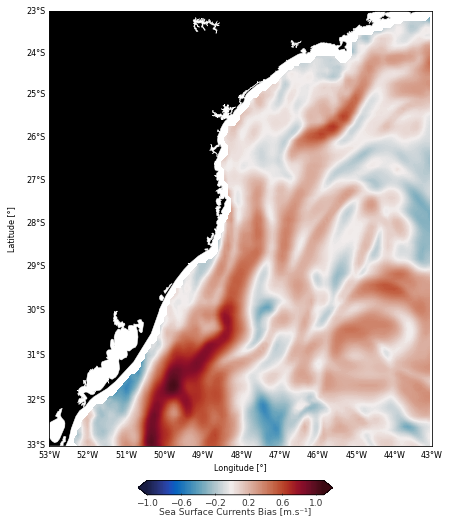

In [57]:
# Create and plot map.
m    = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],llcrnrlon=bbox[0],urcrnrlon=bbox[1], lat_ts=30,resolution='i')
fig  = plt.figure(1,figsize=(10,8))
plt.xlabel('Longitude'u' [\N{DEGREE SIGN}]',labelpad=18,size=8)
plt.ylabel('Latitude'u' [\N{DEGREE SIGN}]',labelpad=33,size=8)
ax   = fig.add_subplot(111)
m.drawparallels(np.arange(-90.,120.,1.), linewidth=0.00, color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=8)
m.drawmeridians(np.arange(-180.,180.,1.), linewidth=0.00,color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=8)
m.drawcountries(color = '#ffffff',linewidth=0.5)
m.drawcoastlines(color = '#ffffff',linewidth=0.5)
m.fillcontinents(color = '#000000')

# Map ticks and gradient.
if metric.value == 1:
    clevs = np.arange(min(rmse_slider.value),max(rmse_slider.value),0.01)
    ticks = np.arange(min(rmse_slider.value),max(rmse_slider.value),0.2)
    cmap  = cmocean.cm.thermal
elif metric.value == 2:
    clevs = np.arange(min(mae_slider.value),max(mae_slider.value),0.01)
    ticks = np.arange(min(mae_slider.options),max(mae_slider.options),0.2)
    cmap  = cmocean.cm.thermal
elif metric.value == 3:
    clevs = np.arange(min(mape_slider.value),max(mape_slider.value),0.15)
    ticks = np.arange(min(mape_slider.options),max(mape_slider.options),2)
    cmap  = cmocean.cm.thermal   
elif metric.value == 4:
    clevs = np.arange(min(bias_slider.value),max(bias_slider.value),0.01)
    ticks = np.arange(min(bias_slider.value),max(bias_slider.value),0.4)
    cmap  = cmocean.cm.balance

# Map pallete and plot
if metric.value  == 1 or metric.value  == 2 or metric.value  == 3:
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,extend="both") 
elif metric.value  == 4:
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,norm=MidpointNormalize(midpoint=0),extend="both")   
cax   = fig.add_axes([0.37, 0.040, 0.27, 0.025])     
cb    = fig.colorbar(h1, cax=cax, orientation="horizontal",panchor=(0.5,0.5),shrink=0.3,ticks=ticks)

# Map legend.
if variable.value == 1 and metric.value == 1:
    cb.set_label(r'Sea Surface Temperature Root Mean Square Error [$^\circ\!$C]', fontsize=9, color='0.2',labelpad=-0.5)
elif variable.value == 1 and metric.value == 2:
    cb.set_label(r'Sea Surface Temperature Mean Absolute Error [$^\circ\!$C]', fontsize=9, color='0.2',labelpad=-0.5)
elif variable.value == 1 and metric.value == 3:
    cb.set_label(r'Sea Surface Temperature Mean Percentage Absolute Error [%]', fontsize=10, color='0.2',labelpad=-0.5)
elif variable.value == 1 and metric.value == 4:
    cb.set_label(r'Sea Surface Temperature Bias [$^\circ\!$C]', fontsize=10, color='0.2',labelpad=-0.5)

elif variable.value == 2 and metric.value == 1:
    cb.set_label(r'Sea Surface Currents Root Mean Square Error [m.s⁻¹]', fontsize=9, color='0.2',labelpad=-0.5)
elif variable.value == 2 and metric.value == 2:
    cb.set_label(r'Sea Surface Currents Mean Absolute Error [m.s⁻¹]', fontsize=9, color='0.2',labelpad=-0.5)    
elif variable.value == 2 and metric.value == 3:
    cb.set_label(r'Sea Surface Currents Absolute Percentage Error [%]', fontsize=9, color='0.2',labelpad=-0.5)
elif variable.value == 2 and metric.value == 4:
    cb.set_label(r'Sea Surface Currents Bias [m.s⁻¹]', fontsize=9, color='0.2',labelpad=-0.5)
cb.ax.tick_params(labelsize=9, length=2, color='0.2', labelcolor='0.2',direction='in') 
cb.set_ticks(ticks)

# Create folder to store figures
try:
    os.makedirs("roms_evaluation")
except FileExistsError:
    pass 

# Save figures.
if dataset.value == 1 and metric.value == 1 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_rmse_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 2 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_mae_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 3 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_mape_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 4 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_bias_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 1 and variable.value == 2:
    plt.savefig('./roms_evaluation/sc_rmse_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)  
elif dataset.value == 1 and metric.value == 2 and variable.value == 2:
    plt.savefig('./roms_evaluation/sc_mae_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 3 and variable.value == 2:
    plt.savefig('./roms_evaluation/sc_mape_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 1 and metric.value == 4 and variable.value == 2:
    plt.savefig('./roms_evaluation/sc_bias_roms_glorys.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 2 and metric.value== 1 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_rmse_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif dataset.value == 2 and metric.value == 2 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_mae_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)  
elif dataset.value == 2 and metric.value == 3 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_mape_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)  
elif dataset.value == 2 and metric.value == 4 and variable.value == 1:
    plt.savefig('./roms_evaluation/sst_bias_roms_oscar.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
